In [20]:
%run w2d1.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
from collections import OrderedDict
from typing import Callable, Dict, Optional, List, Tuple

from tqdm import tqdm
import torch as t
from torch import optim
from torch import nn
import torch.nn.functional as F
from torch import einsum
from einops import rearrange, reduce, repeat
import bert_tests
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
import torchtext

## Tokenization

In [3]:
import transformers
tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-cased")
# print(tokenizer("hello what's up"))
# uncased_tokenizer = transformers.AutoTokenizer.from_pretrained("bert-base-uncased")
# print(uncased_tokenizer(["hello what's up"]))
# coded = uncased_tokenizer(["hello what's up"])
# uncased_tokenizer.batch_decode(coded['input_ids'])
# tokenizer.batch_decode(coded['input_ids'])
# uncased_tokenizer.batch_decode(coded['input_ids'])


## Inference

In [5]:
my_bert, pretrained_bert = load_pretrained_bert()

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [6]:
def feed_bert(model: nn.Module, text: str, tokenizer, top_k: int = 10):
    input_ids: List[int] = tokenizer(text)["input_ids"]
    mask_idxs = [idx for idx, token in enumerate(input_ids) if token == 103]

    all_logits = model(t.tensor([input_ids], dtype=t.long))[0]

    print(text)
    for mask_idx in mask_idxs:
        logits = all_logits[mask_idx]
        probs = t.softmax(logits, dim=0)

        top_logit_idxs = t.argsort(logits, descending=True)[:top_k]
        top_logit_words = tokenizer.decode(top_logit_idxs)

        print(top_logit_words)
        print(probs[top_logit_idxs])
        print()

my_bert.eval()
feed_bert(my_bert, "The fish loves to eat [MASK].", tokenizer, top_k=20)
feed_bert(my_bert, "The fish loves to eat [MASK]", tokenizer, top_k=20)
#feed_bert(my_bert, "The vegetarian fish loves to eat [MASK].", tokenizer, top_k=20)
#feed_bert(my_bert, "The meat-eating fish loves to eat [MASK].", tokenizer, top_k=20)
#feed_bert(my_bert, "The tiny fish loves to eat [MASK].", tokenizer, top_k=20)


The fish loves to eat [MASK].
it fish them meat food eggs honey insects too rice everything water vegetables this fruit apples him there again here
tensor([0.1738, 0.0980, 0.0947, 0.0410, 0.0336, 0.0251, 0.0134, 0.0130, 0.0126,
        0.0119, 0.0092, 0.0090, 0.0088, 0.0083, 0.0072, 0.0069, 0.0063, 0.0060,
        0.0058, 0.0054], grad_fn=<IndexBackward0>)

The fish loves to eat [MASK]
. ;!?..., : | and " but - so । because as [UNK]') with
tensor([9.4125e-01, 4.6098e-02, 1.1822e-02, 4.5820e-04, 1.2235e-04, 5.4506e-05,
        3.6213e-05, 1.6483e-05, 1.2279e-05, 9.2127e-06, 6.5461e-06, 4.6536e-06,
        3.4753e-06, 3.3669e-06, 2.9931e-06, 2.4598e-06, 1.9791e-06, 1.7764e-06,
        1.3952e-06, 1.0635e-06], grad_fn=<IndexBackward0>)



## Fine tuning

In [6]:
bert_tests.test_bert_classification(Bert)

bert MATCH!!!!!!!!
 SHAPE (1, 4, 28996) MEAN: 0.003031 STD: 0.5765 VALS [-0.5742 -0.432 0.1186 -0.7165 -0.5261 0.4967 1.223 0.3165 -0.3247 -0.5716...]
bert MATCH!!!!!!!!
 SHAPE (1, 2) MEAN: 0.09479 STD: 1.411 VALS [-0.903 1.093]


In [7]:
def get_imdb_collate_fn(
    max_seq_length: int,
    tokenizer: transformers.AutoTokenizer,
    device: str,
):
    def fn(raw_xs: List[Tuple[str, str]]) -> Tuple[t.Tensor, t.Tensor]:
        labels: Tuple[str, ...]
        texts: Tuple[str, ...]
        labels, texts = zip(*raw_xs)

        xs = t.tensor(
            tokenizer(
                list(texts),
                padding="longest",
                max_length=max_seq_length,
                truncation=True,
            )['input_ids'],
            dtype=t.long,
            device=device,
        )

        ys = t.tensor([int(l == "pos") for l in labels], dtype=t.long, device=device)

        return xs, ys

    return fn


In [8]:
data_train, data_test = torchtext.datasets.IMDB(root='.data', split=('train', 'test'))
data_train = list(data_train)
data_test = list(data_test)

KeyboardInterrupt: 

In [ ]:
import random

device = "cuda"
collate_fn = get_imdb_collate_fn(512, tokenizer, device)

dl_train_small = DataLoader(
    random.sample(data_train, k=16),
    batch_size=16,
    collate_fn=collate_fn,
    shuffle=True,
)

dl_train = DataLoader(
    data_train,
    batch_size=8,
    collate_fn=collate_fn,
    shuffle=True,
    # num_workers=0,
    # pin_memory=True,
)

dl_test_small = DataLoader(
    random.sample(data_test, k=256),
    batch_size=16,
    collate_fn=collate_fn,
    shuffle=True,
)

dl_test = DataLoader(
    data_test,
    batch_size=2,
    collate_fn=collate_fn,
    shuffle=True,
)


In [ ]:
def get_accuracy(model: nn.Module, dl: DataLoader) -> float:

    num_correct: int = 0
    num_total: int = 0

    model.eval()

    pbar = tqdm(dl, disable=True)
    for x, y in pbar:
        _, out = model(x)
        preds = t.argmax(out, dim=-1)

        num_correct += (preds == y).sum()
        num_total += len(y)
        pbar.set_description(f'acc={num_correct / num_total:.2}')

    return num_correct / num_total

def finetune_bert_epoch(model: nn.Module, dl_train: DataLoader, dl_test: DataLoader) -> nn.Module:
    optimizer = optim.Adam(model.parameters(), lr=1e-5)  # broken?
    pbar = tqdm(enumerate(dl_train))
    for i, (x, y) in pbar:
        optimizer.zero_grad()
        _, out = model(x)
        loss = F.cross_entropy(input=out, target=y)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            pbar.set_description(f'loss={loss.item():.2},acc={get_accuracy(model, dl_test)}')
            model.train()

    return model

my_bert, _ = load_pretrained_bert(num_classes=2)
#for i, (name, p) in enumerate(my_bert.named_parameters()):
#    print(name)
#    p.cuda()

my_bert.cuda()
my_bert.train()

# print(get_accuracy(my_bert, dl_test_small))
import gc
gc.collect()
t.cuda.empty_cache()
epochs = 100
for i in range(epochs):
    print(i)
    model = finetune_bert_epoch(my_bert, dl_train=dl_train, dl_test=dl_test_small)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


0


loss=0.012,acc=0.9375: : 3125it [16:13,  3.21it/s]    


1


loss=0.34,acc=0.90234375: : 1245it [06:28,  3.20it/s]  


KeyboardInterrupt: 

In [ ]:
%pdb

Automatic pdb calling has been turned ON


## Training from Scratch on Masked Language Modeling

In [4]:
import torchtext
data_train, data_test = torchtext.datasets.WikiText2(root='.data', split=('train', 'test'))

data_train = list(data_train)
data_test = list(data_test)
print(f"Sizes before filtering: {len(data_train)}, {len(data_test)}")

Sizes before filtering: 36718, 4358


In [5]:
def wiki_include(text: str) -> bool:
    tokens = text.split(" ")
    if len(tokens) < 5:
        return False
    if "=" in tokens:
        return False
    return True

data_train = [x for x in data_train if wiki_include(x)]
data_test = [x for x in data_test if wiki_include(x)]
print(f"Sizes after filtering: {len(data_train)}, {len(data_test)}")

Sizes after filtering: 17262, 2072


In [6]:
def get_wiki_collate_fn(
    max_seq_length: int,
    tokenizer: transformers.PreTrainedTokenizerBase,
    pred_frac: float,
    mask_frac: float,
    random_frac: float,
    device: str,
):
    assert 0 <= pred_frac <= 1 and 0 <= mask_frac <= 1 and 0 <= random_frac <= 1
    assert 0 <= mask_frac + random_frac <= 1

    def fn(texts: List[str]) -> Tuple[t.Tensor, t.Tensor]:
        # TODO: Sample random substring of texts to have more data diversity?
        xs = t.tensor(
            tokenizer(
                list(texts),
                padding="longest",
                max_length=max_seq_length,
                truncation=True,
            )["input_ids"],
            dtype=t.long,
            device=device,
        )

        pred_mask = (t.rand_like(xs, dtype=t.float) < pred_frac) & (
            (xs != tokenizer.pad_token_id) & (xs != tokenizer.cls_token_id) &
            (xs != tokenizer.eos_token_id) & (xs != tokenizer.sep_token_id)
        )
        ys = t.masked_select(xs, pred_mask)

        r = t.rand_like(xs, dtype=t.float)
        mask_mask = r < mask_frac
        random_mask = (mask_frac <= r) & (r < mask_frac + random_frac)

        xs[pred_mask & mask_mask] = tokenizer.mask_token_id

        random_input_ids = t.randint(
            low=0, high=len(tokenizer), size=xs.shape, dtype=t.long, device=device
        )
        xs[pred_mask & random_mask] = random_input_ids[pred_mask & random_mask]

        return xs, pred_mask, ys

    return fn


In [33]:
import random

random.seed(0)

device = "cuda"
collate_fn = get_wiki_collate_fn(
    max_seq_length=8,
    tokenizer=transformers.AutoTokenizer.from_pretrained("bert-base-cased"),
    pred_frac=0.15,
    mask_frac=1,
    random_frac=0,
    device=device,
)

dl_train_small = DataLoader(
    random.sample(data_train, k=2),
    batch_size=4,
    collate_fn=collate_fn,
    shuffle=True,
)

dl_train = DataLoader(
    data_train,
    batch_size=16,
    collate_fn=collate_fn,
    shuffle=True,
)

dl_test_small = DataLoader(
    random.sample(data_test, k=256),
    batch_size=16,
    collate_fn=collate_fn,
    shuffle=True,
)

dl_test = DataLoader(
    data_test,
    batch_size=16,
    collate_fn=collate_fn,
    shuffle=True,
)


In [34]:
def get_mlm_accuracy(model: nn.Module, dl: DataLoader) -> float:
    num_correct: int = 0
    num_total: int = 0

    model.eval()

    pbar = tqdm(dl, disable=True)
    for x, pred_mask, y in pbar:
        if len(y) == 0:
            continue
        logits = model(x)
        pred_logits_flat = t.masked_select(logits, pred_mask.unsqueeze(-1))
        pred_logits = pred_logits_flat.reshape((-1, logits.shape[-1]))
        preds = t.argmax(pred_logits, dim=-1)

        num_correct += (preds == y).sum()
        num_total += len(y)
        pbar.set_description(f'acc={num_correct / num_total:.2}')

    if num_total == 0:
        return 0.0
    return num_correct / num_total

def mlm_epoch(model: nn.Module, dl_train: DataLoader, dl_test: DataLoader, lr: float, opbar=None) -> nn.Module:
    optimizer = optim.Adam(model.parameters(), lr=lr)  # broken?
    pbar = tqdm(enumerate(dl_train), leave=False)
    for i, (x, pred_mask, y) in pbar:
        if len(y) == 0:
            continue
        optimizer.zero_grad()
        logits = model(x)
        pred_logits_flat = t.masked_select(logits, pred_mask.unsqueeze(-1))
        pred_logits = pred_logits_flat.reshape((-1, logits.shape[-1]))
        loss = F.cross_entropy(input=pred_logits, target=y)
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            pbar.set_description(f'loss={loss.item():.3f},acc={get_mlm_accuracy(model, dl_test):.3f}')
            model.train()
            if opbar is not None:
                opbar.set_description(f'loss={loss.item():.3f},acc={get_mlm_accuracy(model, dl_test):.3f}')
            # print(tokenizer.decode(y))

    return model

In [55]:
tiny_bert = Bert(
    vocab_size=28996,
    hidden_size=256,
    max_position_embeddings=512,
    type_vocab_size=2,
    dropout=0,
    intermediate_size=1024,
    num_heads=12,
    num_layers=2,
)
tiny_bert.to(device)
None
losses = []

In [56]:
# tiny_bert.train()
# epochs = 1000
# pbar = tqdm(range(epochs))
# for i in pbar:
#     # print(i)
#     mlm_epoch(tiny_bert, dl_train_small, dl_train_small, 1e-3, pbar)

In [57]:
batch_x = t.tensor(
    tokenizer(["The cow likes to eat grass"])["input_ids"],
    device="cuda",
    dtype=t.long,
)

pred_mask = t.tensor(
    [[False, False, False, False, True, False, True, False]],
    dtype=t.bool,
    device="cuda",
)

batch_y = t.masked_select(
    batch_x,
    pred_mask,
)
batch_x[pred_mask] = tokenizer.mask_token_id
print(tokenizer.decode(batch_x[0]))
print(tokenizer.decode(batch_y))

tiny_bert.train()
optimizer = optim.Adam(tiny_bert.parameters(), lr=1e-4)  # broken?
for i in range(100):
    optimizer.zero_grad()
    logits = tiny_bert(batch_x)
    pred_logits_flat = t.masked_select(logits, pred_mask.unsqueeze(-1))
    pred_logits = pred_logits_flat.reshape((-1, logits.shape[-1]))
    loss = F.cross_entropy(input=pred_logits, target=batch_y)
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    
    if i % 1 == 0:
        print(i, loss.item())

[CLS] The cow likes [MASK] eat [MASK] [SEP]
to grass
0 81.80654907226562
1 45.52915954589844
2 15.281932830810547
3 0.0645010769367218
4 0.0
5 0.0
6 0.0
7 0.0
8 0.0
9 0.0
10 0.0
11 0.0
12 0.0
13 0.0
14 0.0
15 0.0
16 0.0
17 0.0
18 0.0
19 0.0
20 0.0
21 0.0
22 0.0
23 0.0
24 0.0
25 0.0
26 0.0
27 0.0
28 0.0
29 0.0
30 0.0
31 0.0
32 0.0
33 0.0
34 0.0
35 0.0
36 0.0
37 0.0
38 0.0
39 0.0
40 0.0
41 0.0
42 0.0
43 0.0
44 0.0
45 0.0
46 0.0
47 0.0
48 0.0
49 0.0
50 0.0
51 0.0
52 0.0
53 0.0
54 0.0
55 0.0
56 0.0
57 0.0
58 0.0
59 0.0
60 0.0
61 0.0
62 0.0
63 0.0
64 0.0
65 0.0
66 0.0
67 0.0
68 0.0
69 0.0
70 0.0
71 0.0
72 0.0
73 0.0
74 0.0
75 0.0
76 0.0
77 0.0
78 0.0
79 0.0
80 0.0
81 0.0
82 0.0
83 0.0
84 0.0
85 0.0
86 0.0
87 0.0
88 0.0
89 0.0
90 0.0
91 0.0
92 0.0
93 0.0
94 0.0
95 0.0
96 0.0
97 0.0
98 0.0
99 0.0


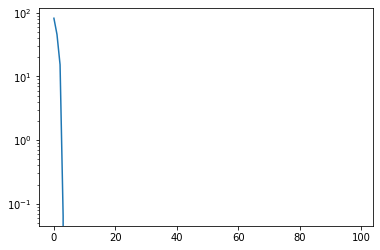

In [58]:
plt.plot(losses)
plt.yscale("log")

In [59]:
tiny_bert.eval()
feed_bert(tiny_bert, "The cow likes [MASK] eat [MASK]", tokenizer, top_k=10)


[4, 6]
The cow likes [MASK] eat [MASK]
to grass broad them Kara fatty stickingtablepolis Leipzig
tensor([118.074684143,  74.696380615,  69.747146606,  62.994777679,
         62.295448303,  61.308742523,  60.646953583,  59.622581482,
         59.100559235,  57.633613586], device='cuda:0',
       grad_fn=<IndexBackward0>)

grass to ha sticking openings viewed injured Leipzig sweating traditionally
tensor([112.907119751,  82.508247375,  64.210861206,  60.710426331,
         57.982177734,  57.629398346,  57.253246307,  55.806079865,
         55.079479218,  54.625976562], device='cuda:0',
       grad_fn=<IndexBackward0>)



In [26]:
from torch.utils.hooks import RemovableHandle

class HookHandler:
    def __init__(self):
        self.activations = {}
        self.hook_handles: List[RemovableHandle] = []

    def reset(self):
        for h in self.hook_handles:
            h.remove()

        self.activations = {}
        self.hook_handles = []

    def __enter__(self):
        return self

    def __exit__(self, exc_type, exc_value, exc_traceback): 
        self.reset()
        print("All hooks removed!")

    def add_save_activation_hook(
        self,
        mod: nn.Module,
        key: str,
    ):
        def fn(model, input, output):
            self.activations[key] = output.detach()

        self.hook_handles.append(mod.register_forward_hook(fn))

In [27]:
def acts_all_close(acts: t.Tensor, rtol: float = 1e-3):
    return t.allclose(acts[0][0], acts[0][1], rtol=rtol)

tiny_bert.eval()
with HookHandler() as hh:
    hh.add_save_activation_hook(tiny_bert.embedding, "embed")
    hh.add_save_activation_hook(tiny_bert.transformer[0].mha, "t0.mha")
    hh.add_save_activation_hook(tiny_bert.transformer[0], "t0")
    hh.add_save_activation_hook(tiny_bert.lm_head.mlp, "final_mlp")

    x = tokenizer(["The cow likes [MASK] eat [MASK]"])["input_ids"]
    logits = tiny_bert(t.tensor(x, dtype=t.long).cuda())

    print("embed", acts_all_close(hh.activations["embed"]))
    print("t0.mha", acts_all_close(hh.activations["t0.mha"], rtol=1e-3))
    print(hh.activations["t0.mha"])
    print("t0", acts_all_close(hh.activations["t0"], rtol=1e-3))
    print("final_mlp", acts_all_close(hh.activations["final_mlp"]))
    print("logits", acts_all_close(logits))  # The same


embed False
t0.mha False
tensor([[[ 0.7536, -0.4107,  0.9130,  ..., -0.3842, -0.2859,  0.1704],
         [ 0.7461, -0.2790,  0.8417,  ..., -0.4808, -0.2501,  0.1761],
         [ 0.7771, -0.3439,  0.8944,  ..., -0.4111, -0.2806,  0.1313],
         ...,
         [ 0.7699, -0.3196,  1.0425,  ..., -0.3886, -0.1184,  0.0708],
         [ 0.8119, -0.3057,  0.9970,  ..., -0.4310, -0.1342, -0.0458],
         [ 0.7588, -0.3539,  0.9478,  ..., -0.3831, -0.2835,  0.1142]]],
       device='cuda:0')
t0 False
final_mlp False
logits False
All hooks removed!


In [28]:
def feed_bert(model: nn.Module, text: str, tokenizer, top_k: int = 10):
    input_ids: List[int] = tokenizer(text)["input_ids"]
    mask_idxs = [idx for idx, token in enumerate(input_ids) if token == tokenizer.mask_token_id]
    print(mask_idxs)

    all_logits = model(t.tensor([input_ids], dtype=t.long))[0]

    print(text)
    for mask_idx in mask_idxs:
        logits = all_logits[mask_idx]
        probs = t.softmax(logits, dim=0)

        top_logit_idxs = t.argsort(logits, descending=True)[:top_k]
        top_logit_words = tokenizer.decode(top_logit_idxs)

        t.set_printoptions(precision=9)
        print(top_logit_words)
        print(logits[top_logit_idxs])
        print()
        t.set_printoptions(precision=4)

In [43]:
tiny_bert.eval()
for (x, mask, y) in dl_train_small:
    print(tokenizer.batch_decode(x))
    print(tokenizer.decode(y))
    print("*****************************")
    logits = tiny_bert(x)
    #print(logits.shape)
    # print(t.sort(logits, dim=-1).values[:, :3, -10:])
    print("-----------------------")
    for xx in x:
        feed_bert(tiny_bert, tokenizer.decode(xx), tokenizer, top_k=5)
        print("---------------------------------------")


['[CLS] At the base of [MASK] of [SEP]', '[CLS] Languages which [MASK] not commonly [MASK] [SEP]']
each may use
*****************************
-----------------------
[6]
[CLS] At the base of [MASK] of [SEP]
of base ferry publishes At
tensor([106.016815186,  60.250469208,  59.121616364,  57.998916626,
         57.417720795], device='cuda:0', grad_fn=<IndexBackward0>)

---------------------------------------
[4, 7]
[CLS] Languages which [MASK] not commonly [MASK] [SEP]
not of Rey uselev
tensor([95.449081421, 88.146469116, 68.647972107, 66.169685364, 63.083419800],
       device='cuda:0', grad_fn=<IndexBackward0>)

use IF fibers storyline Emily
tensor([93.822265625, 65.338890076, 62.282360077, 62.149761200, 61.994091034],
       device='cuda:0', grad_fn=<IndexBackward0>)

---------------------------------------


In [ ]:
test_bert, _ = load_pretrained_bert(num_classes=2)

In [1]:
test_bert.eval()
for (x, mask, y) in dl_train_small:
    print(tokenizer.batch_decode(x))
    print(tokenizer.decode(y))
    print("*****************************")
    logits, _ = test_bert(x)
    #print(logits.shape)
    # print(t.sort(logits, dim=-1).values[:, :3, -10:])
    print("-----------------------")
    for xx in x:
        feed_bert(lambda x : test_bert(x)[0], tokenizer.decode(xx), tokenizer, top_k=5)
        print("---------------------------------------")


NameError: name 'test_bert' is not defined

In [162]:
tiny_bert.lm_head.unembedding.weight

Parameter containing:
tensor([[-0.0390,  0.1328, -0.0412,  ...,  0.1419,  0.0393,  0.0362],
        [-0.0796,  0.1322, -0.1050,  ...,  0.1515,  0.0561,  0.0403],
        [-0.0453,  0.0650, -0.0387,  ...,  0.0973,  0.1245,  0.0768],
        ...,
        [-0.1224,  0.1273, -0.0526,  ...,  0.1105,  0.0831,  0.0459],
        [-0.0134,  0.0756, -0.1486,  ...,  0.1267,  0.0428,  0.1165],
        [-0.0816,  0.1368, -0.0750,  ...,  0.0707,  0.1486,  0.1435]],
       device='cuda:0', requires_grad=True)

In [163]:
tiny_bert.lm_head.unembedding.bias

Parameter containing:
tensor([-0.0315, -0.0883, -0.0943,  ..., -0.0812, -0.0664, -0.1027],
       device='cuda:0', requires_grad=True)